Using device: cuda
[128, 512, 512, 512, 512, 512]
Files already downloaded and verified
ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

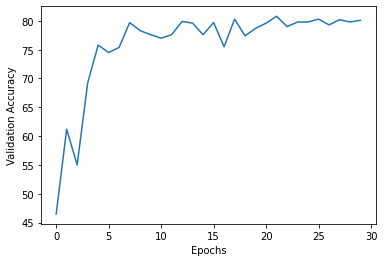

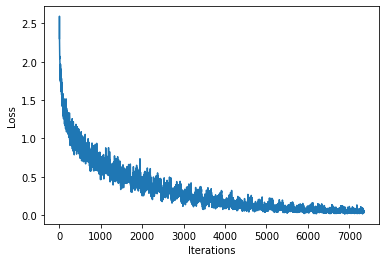

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.0)

    #Using Kaiming weight initialization considering the ReLu activation used in the network
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        m.bias.data.fill_(0.0)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

torch.manual_seed(2)


#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 30 #Default: 20
batch_size = 200 #Default: 200
learning_rate = 2e-3 #Default: 2e-3
learning_rate_decay = 0.95 #Default: 0.95
reg=0.001 #Default: 0.001
num_training= 49000
num_validation =1000
norm_layer = "batch"
use_dropout = False
dropout_value = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p = 0.25
print(hidden_size)


#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
#################################################################################
# TODO: Q3.a Chose the right data augmentation transforms with the right        #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################
data_aug_transforms = [
    # transforms.Resize((40, 40)),
    # transforms.RandomCrop((32, 32)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    # torchvision.transforms.Grayscale(num_output_channels=3),
]
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='/datasets/',
                                           train=True,
                                           transform=norm_transform, download=True
                                           )

test_dataset = torchvision.datasets.CIFAR10(root='/datasets/',
                                          train=False,
                                          transform=test_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


#-------------------------------------------------
# Convolutional neural network (Q1.a and Q2.a)
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None, dropout=False, dropout_value=0.3):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # For Q1.a make use of conv2d and relu layers from the torch.nn module.         #
        # For Q2.a make use of BatchNorm2d layer from the torch.nn module.              #
        # For Q3.b Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        if norm_layer == None:
          #From various references, considering the kernel size of 3x3 (over 1x1 or 4x4 filters) which is popular for better feature extraction
          #Size of padding is calculated using the formula: P = ((F-1)/2)
          #Can't experiment extensively with Stride/Filter/Pad in Conv and FC Layers as hidden layer sizes are fixed

          self.conv = nn.Sequential(
                        nn.Conv2d(input_size, hidden_size[0], kernel_size = 3, stride=1, padding=1, padding_mode='zeros'),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),

                        nn.Conv2d(hidden_size[0], hidden_size[1], kernel_size = 3, stride=1, padding=1),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),

                        nn.Conv2d(hidden_size[1], hidden_size[2], kernel_size = 3, stride=1, padding=1),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),

                        nn.Conv2d(hidden_size[2], hidden_size[3], kernel_size = 3, stride=1, padding=1),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),

                        nn.Conv2d(hidden_size[3], hidden_size[4], kernel_size = 3, stride=1, padding=1),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU())
          
          self.fc = nn.Sequential(nn.Linear(hidden_size[5], num_classes))

        # Adding batch norm if batch norm flag is enabled  
        elif norm_layer != None and not dropout:
          self.conv = nn.Sequential(
                        nn.Conv2d(input_size, hidden_size[0], kernel_size = 3, stride=1, padding=1, padding_mode='zeros'),
                        nn.BatchNorm2d(hidden_size[0]),  #Q2 needs batch-norm code, so i'm just experimenting this part
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        
                        #Simillarly need to write batchnorm code for hidden_size: 1, 2, 3, 4
                        nn.Conv2d(hidden_size[0], hidden_size[1], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[1]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        
                        nn.Conv2d(hidden_size[1], hidden_size[2], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[2]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        
                        nn.Conv2d(hidden_size[2], hidden_size[3], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[3]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        
                        nn.Conv2d(hidden_size[3], hidden_size[4], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[4]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU())
          
          self.fc = nn.Sequential(nn.Linear(hidden_size[5], num_classes))

        # Adding dropout if dropout flag is enabled                
        elif norm_layer != None and dropout:
          self.conv = nn.Sequential(
                        nn.Conv2d(input_size, hidden_size[0], kernel_size = 3, stride=1, padding=1, padding_mode='zeros'),
                        nn.BatchNorm2d(hidden_size[0]),  #Q2 needs batch-norm code, so i'm just experimenting this part
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        nn.Dropout(dropout_value),

                        #Simillarly need to write batchnorm code for hidden_size: 1, 2, 3, 4
                        nn.Conv2d(hidden_size[0], hidden_size[1], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[1]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        nn.Dropout(dropout_value),

                        nn.Conv2d(hidden_size[1], hidden_size[2], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[2]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        nn.Dropout(dropout_value),

                        nn.Conv2d(hidden_size[2], hidden_size[3], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[3]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        nn.Dropout(dropout_value),

                        nn.Conv2d(hidden_size[3], hidden_size[4], kernel_size = 3, stride=1, padding=1),
                        nn.BatchNorm2d(hidden_size[4]),
                        nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(),
                        nn.Dropout(dropout_value))
          

            #1D Batch norm for final layer
          self.fc = nn.Sequential(nn.ReLU(), nn.Linear(hidden_size[5], num_classes))
        
        self.layers = [self.conv, self.fc]
        # self.layers = nn.Sequential(*layers)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.conv(x)

        #Returns tensor x with all the dimensions of input of size 1 removed
        x = x.squeeze()

        #send the flattened input to fully connect layer
        out = self.fc(x)  #This output is then passed through softmax to retrieve probability distribution of classes

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


#-------------------------------------------------
# Calculate the model size (Q1.b)
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # TODO: Implement the function to count the number of trainable parameters in   #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    model_s = []
    for i in model.parameters():
      if i.requires_grad:
        model_s.append(i.numel())
    model_sz = sum(model_s)
    print("Number of trainable parameters = ", model_sz)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model_sz

#-------------------------------------------------
# Calculate the model size (Q1.c)
# visualize the convolution filters of the first convolution layer of the input model
#-------------------------------------------------
def VisualizeFilter(model):
    #################################################################################
    # TODO: Implement the functiont to visualize the weights in the first conv layer#
    # in the model. Visualize them as a single image fo stacked filters.            #
    # You can use matlplotlib.imshow to visualize an image in python                #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    filters = model.layers[0][0].weight.data.cpu().numpy()
    fig = plt.figure()
    fig_row = 8
    fig_col=16
    for idx in range(1, fig_row*fig_col + 1):
      sub_fig = fig.add_subplot(fig_row, fig_col, idx)
      sub_fig.axes.set_xticks([])
      sub_fig.axes.set_yticks([])
      plt.imshow((filters[idx-1, ...] - np.min(filters[idx-1]))/ (np.max(filters[idx-1] - np.min(filters[idx-1]))))
    plt.show()
    return
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#======================================================================================
# Q1.a: Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------

# looping over all values of p to find the best model. 
# for p in dropout_value:
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer, dropout=use_dropout, dropout_value=p).to(device)

# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
# Print the model
print(model)
# Print model size
#======================================================================================
# Q1.b: Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)
#======================================================================================
# Q1.a: Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
#======================================================================================
VisualizeFilter(model)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
Val_Acc = []
Losses = []
lr = learning_rate
total_step = len(train_loader)
best_accuracy=0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        Losses.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Validatation Accuracy is: {} %'.format(100 * (correct / total)))
        Val = 100 * (correct / total)
        Val_Acc.append(Val)
        #################################################################################
        # TODO: Q2.b Implement the early stopping mechanism to save the model which has #
        # acheieved the best validation accuracy so-far.                                #
        #################################################################################
        #best_model = None
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        cur_accuracy = 100 * correct / total
        if cur_accuracy>best_accuracy:
            best_accuracy = cur_accuracy
            best_model = model
            print("best")
            torch.save(best_model.state_dict(),'./best_model.ckpt')

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model.train()

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
#################################################################################
# TODO: Q2.b Implement the early stopping mechanism to load the weights from the#
# best model so far and perform testing with this model.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
model.load_state_dict(torch.load('./best_model.ckpt'))
model.eval()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * (correct / total)))
    #Val = 100 * (correct / total)
    #Val_Acc.append(Val)

# Q1.c: Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
#VisualizeFilter(model)

#Print Validation Accuracy v/s Epoch
plt.plot(Val_Acc, label = "Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

#Print Loss v/s Epoch
plt.plot(Losses, label = "Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
